# Step 1) Data Preparation

In [1]:
import pandas as pd

df = pd.read_csv("../0_data/INTC.csv",infer_datetime_format=True, parse_dates=['dt'], index_col=['dt'])

trainCount=int(len(df)*0.4)
dfTrain = df.iloc[:trainCount]

dfTest = df.iloc[trainCount:]
dfTest.to_csv('local_test/test_dir/input/data/training/data.csv')
dfTest.head()

,open,low,high,close,vol
dt,,,,,
2014-08-13,33.24,34.15,33.23,34.10,36291008.0
2014-08-14,34.05,34.23,33.74,33.94,25457954.0
2014-08-15,34.10,34.21,33.71,34.17,28582224.0
2014-08-16,34.10,34.21,33.71,34.17,28582224.0
2014-08-17,34.10,34.21,33.71,34.17,28582224.0


<IPython.core.display.Javascript object>


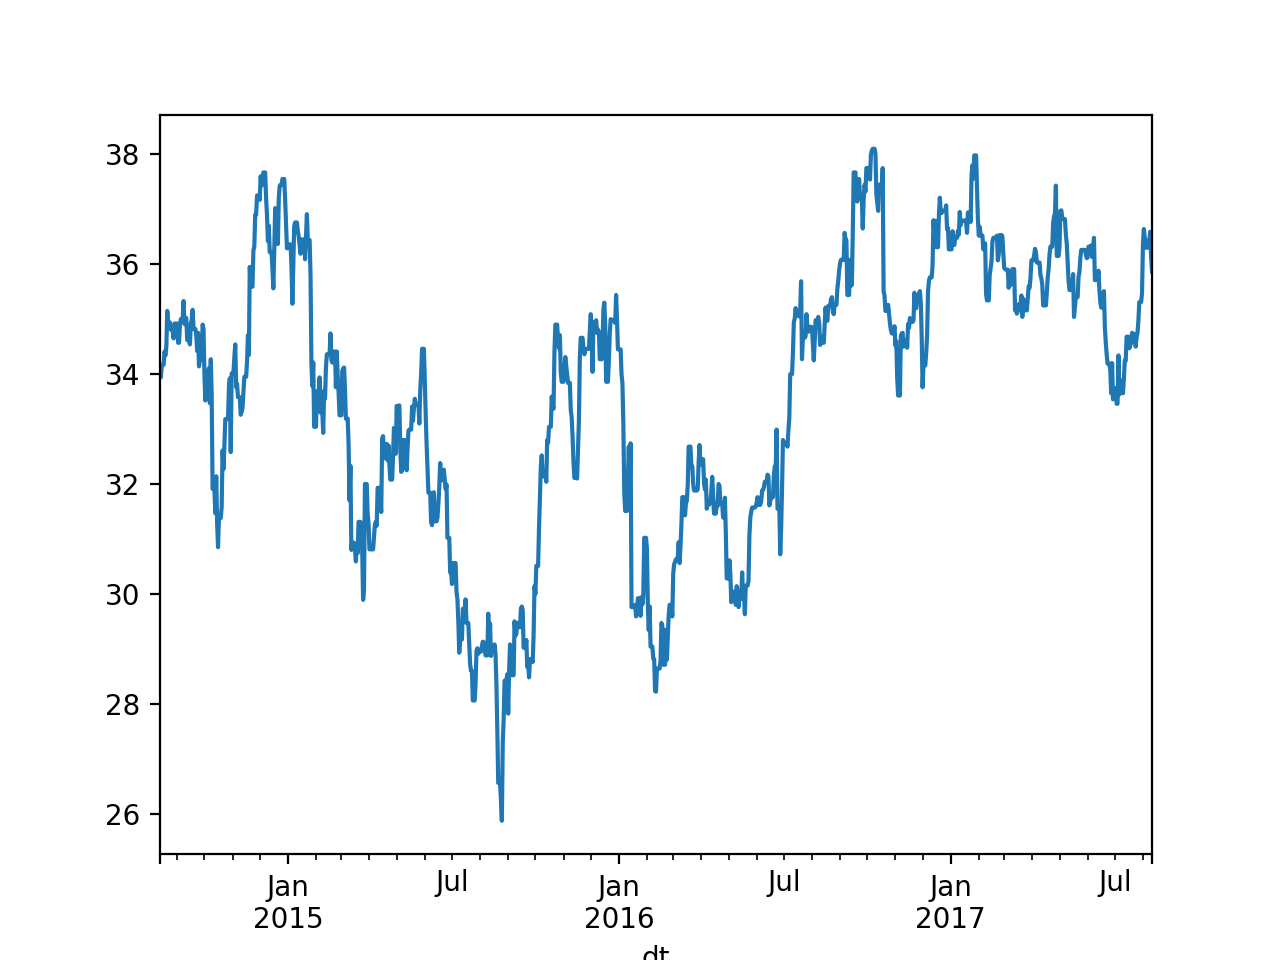

In [2]:
%matplotlib notebook
dfTest["close"].plot()

# Step 2) Modify Strategy Configuration 

In the following cell, please change the parameter `user` to your name and adjust the other parameters for the strategy.
* `user` = Username for Leaderboard
* `long_threshold` = Threshold for Long Trade (0 to 1)
* `short_threshold` = Threshold for Short Trade (0 to 1)
* `profit_target` = Profit Target in Points (e.g. 20)
* `stop_target` = Stop Target in Points (e.g. 10)

`Tip`: A good starting point for improving the strategy is modify the profit / stop target and the risk/reward ratio. Another option is to reduce the number of signals by increasing the threshold.

In [ ]:
%%writefile model/algo_config
{ "user" : "myusername",
  "submitUrl" : "",
  "long_threshold" : 0.5,
  "short_threshold" : 0.5,
  "profit_target" : 1.00,
  "stop_target" : 0.50,
  "size" : 1000
}

In [ ]:
%run update_config.py ml_long_short_predict

# Step 3) Modify Strategy Code

In the following cell, you can modify the strategy code. For the first backtests, you can leave it as is.

`Tip`: A good starting point for improving the strategy is to combine the signal from the model with traditional trend indicators (e.g. moving average). This will likely improve the performance. To improve the strategy further, you could increase the accuracy of the machine learning model by including more indicators (e.g. ATR) or modify the input and forecast window. This requires to re-train the machine learning model as this needs to match your strategy. For timeseries forecasting, you could compare the performance with more advanced ML networks (e.g. CNN, LTSM, RNN) and pick the model with the best predictions.

You can also checkout other AWS-provided options for timeseries forecasting and formulate a strategy that uses price predictions and integrate them in your strategy:
* https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html 
* https://aws.amazon.com/forecast/

Here are some helpful links:
* Backtrader Documentation: https://www.backtrader.com/docu/strategy/
* TA-Lib Indicator Reference: https://www.backtrader.com/docu/talibindautoref/
* Backtrader Indicator Reference: https://www.backtrader.com/docu/indautoref/

In [ ]:
%%writefile model/algo_ml_long_short_predict.py
import backtrader as bt
from algo_base import *
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import load_model

class MyStrategy(StrategyTemplate):

    def __init__(self):
        super(MyStrategy, self).__init__()
        self.dataclose = self.datas[0].close
        
        self.lastDay=-1
        self.lastMonth=-1
                
        self.order=None
        self.orderPlaced=False
                                
        self.model = load_model('model_long_short_predict.h5')
        
        # input / indicators
        self.repeatCount=15
        self.repeatStep=1
        
        self.profitTarget=self.config["profit_target"]
        self.stopTarget=self.config["stop_target"]
        
        self.sma=[]
        self.roc=[]
        self.hData=["dt"]
        self.hData.append("time")
  
        for a in range(0,self.repeatCount):
            tp=(a+1)*self.repeatStep
            self.hData.append("sma"+str(tp))
            self.sma.append(bt.talib.SMA(self.data, timeperiod=tp))
        for a in range(0,self.repeatCount):
            tp=(a+1)*self.repeatStep
            self.hData.append("roc"+str(tp))
            self.roc.append(bt.talib.ROC(self.data, timeperiod=tp))
               
    def next(self):
        dt=self.datas[0].datetime.datetime(0)
            #SOM
            if self.lastMonth!=dt.month:
                if self.lastMonth!=-1:
                    chg=self.broker.getvalue()-self.monthCash
                    print("[%s]:chg=%.2f,cash=%.2f" % (dt,chg,self.broker.getvalue()))
                self.lastMonth=dt.month
                self.monthCash=self.broker.getvalue()

            cl=self.dataclose[0]
            #SOD
            if self.lastDay!=dt.day:
                self.lastDay=dt.day
                #print("[%s]: SOD" % (dt))
                self.orderPlaced=False

                self.lowPrice=cl
                self.highPrice=cl
                self.openPrice=cl

            if cl<self.lowPrice:
                self.lowPrice=cl
            elif cl>self.highPrice:
                self.highPrice=cl

            inputRec=[]                
            t=dt.minute+dt.hour*60
            inputRec.append(t/(60*24))
            
            #open,low,high,close
            inputRec0=[]
            inputRec0.append(self.openPrice)
            inputRec0.append(self.lowPrice)
            inputRec0.append(self.highPrice)
            inputRec0.append(cl)
            
            #sma
            for a in range(0,self.repeatCount):
                if math.isnan(self.sma[a][0]):
                    inputRec0.append(cl)
                else:
                    inputRec0.append(self.sma[a][0])

            m1=min(inputRec0)
            m2=max(inputRec0)
            for a in inputRec0:
                if m2-m1==0:
                    inputRec.append(0)
                else:
                    inputRec.append((a-m1)/(m2-m1))
            
            #roc
            for a in range(0,self.repeatCount):
                if math.isnan(self.roc[a][0]):
                    inputRec.append(0)
                else:
                    inputRec.append(self.roc[a][0])

            mX=[]
            mX.append(np.array(inputRec))
            dataX=np.array(mX)
            #print("dataX=%s" % dataX)
            
            # *** ML prediction ***
            mY=self.model.predict(dataX)
            #print("mY=%s" % mY)
            tLong=mY[0][0]
            tShort=mY[0][1]
            #print("[%s]:long=%s,short=%s" % (dt,tLong,tShort))
            if not self.position and not self.order:
                fLong=(tLong>self.config["long_threshold"]) 
                fShort=(tShort>self.config["short_threshold"])
                if fLong:
                    #print("[%s]:Go Long:long=%s,short=%s" % (dt,tLong,tShort))
                    self.order=self.buy()
                    self.limitPrice=cl+self.profitTarget
                    self.stopPrice=cl-self.stopTarget
                    self.orderPlaced=True
                elif fShort:
                    #print("[%s]:Go Short:long=%s,short=%s" % (dt,tLong,tShort))
                    self.order=self.sell()                    
                    self.limitPrice=cl-self.profitTarget
                    self.stopPrice=cl+self.stopTarget
                    self.orderPlaced=True

            if self.position:
                if self.position.size>0:
                    if cl>=self.limitPrice or cl<=self.stopPrice:
                        self.order=self.sell()
                elif self.position.size<0:
                    if cl<=self.limitPrice or cl>=self.stopPrice:
                        self.order=self.buy()

# Step 4) Backtest Locally (without submitting performance)

In [ ]:
#Build Local Algo Image
!docker build -t algo_$(cat model/algo_name) .
!docker run -v $(pwd)/local_test/test_dir:/opt/ml --rm algo_$(cat model/algo_name) train

In [ ]:
from IPython.display import Image
Image(filename='local_test/test_dir/model/chart.png')

## Refine your trading strategy (step 2 to 4). Once you are ready to submit the performance of your strategy, move on to the next step.

# Step 5) Run Backtest on SageMaker and submit performance

In [ ]:
#Deploy Algo Image to ECS
!./build_and_push.sh

In [ ]:
#Run Remote Backtesting via SageMaker
import sagemaker as sage
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator 

role = get_execution_role()
sess = sage.Session()

WORK_DIRECTORY = 'local_test/test_dir/input/data/training'
data_location = sess.upload_data(WORK_DIRECTORY, key_prefix='data')
print(data_location)

with open('model/algo_config', 'r') as f:
    config = json.load(f)
algo_name=config['algo_name']

prefix='algo_'+algo_name
job_name=prefix.replace('_','-')

account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = f'{account}.dkr.ecr.{region}.amazonaws.com/{prefix}:latest'

algo = sage.estimator.Estimator(
    image_name=image,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    output_path="s3://{}/output".format(sess.default_bucket()),
    sagemaker_session=sess,
    base_job_name=job_name,
    hyperparameters=config,
    metric_definitions=[
        {
            "Name": "algo:pnl",
            "Regex": "Total PnL:(.*?)]"
        },
        {
            "Name": "algo:sharpe_ratio",
            "Regex": "Sharpe Ratio:(.*?),"
        }
    ])
algo.fit(data_location)

In [ ]:
#Get Algo Metrics
from sagemaker.analytics import TrainingJobAnalytics

latest_job_name = algo.latest_training_job.job_name
metrics_dataframe = TrainingJobAnalytics(training_job_name=latest_job_name).dataframe()
metrics_dataframe

In [ ]:
#Get Algo Chart from S3
model_name=algo.model_data.replace('s3://'+sess.default_bucket()+'/','')
import boto3
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(sess.default_bucket())
my_bucket.download_file(model_name,'model.tar.gz')
!tar -xzf model.tar.gz
!rm model.tar.gz
from IPython.display import Image
Image(filename='chart.png') 